[*********************100%***********************]  1 of 1 completed
RMSE: 0.022937503182139017
MAE: 0.017079431305184616
R2: 0.9414605729455645
MAPE: 0.02%
Theil U statistic : 0.22
Initial Balance: $1000
Final Balance: $1068.89
Profit or Loss: $68.89


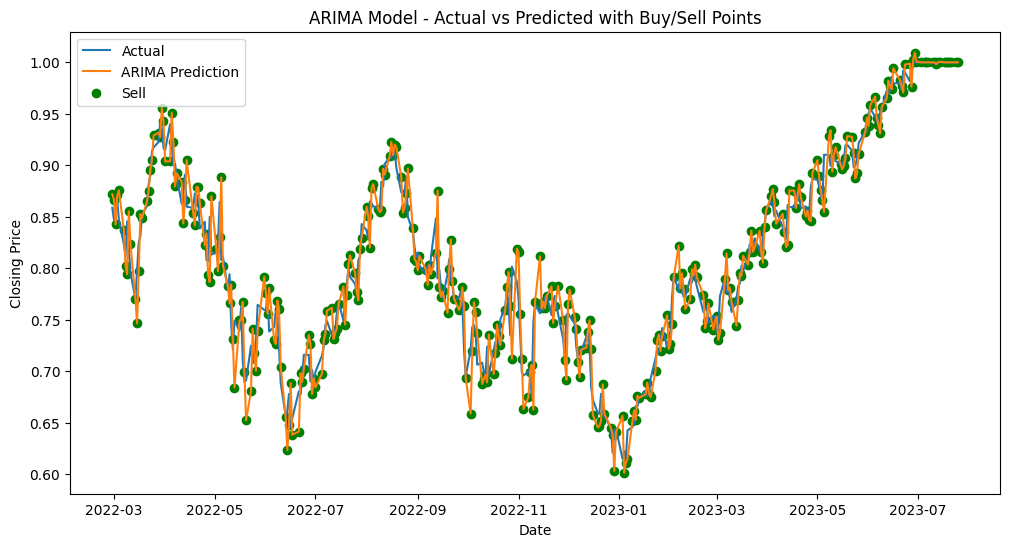

In [8]:
import warnings
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import yfinance as yf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA

warnings.simplefilter("ignore")

tf.random.set_seed(455)
np.random.seed(455)

ticker = "AAPL"
end = datetime.now()
start = datetime(2016, end.month, end.day)
dataset = yf.download(ticker, start, end)

# Data Cleaning
# Handle Missing Data
dataset = dataset.dropna()  # Remove rows with missing data

# Remove Duplicates
dataset = dataset[~dataset.index.duplicated(keep='first')]

# Handle Outliers (Clipping values)
lower_bound = 0  # Define lower bound for clipping
upper_bound = np.percentile(dataset['Close'], 99)  # Define upper bound for clipping (99th percentile)
dataset['Close'] = np.clip(dataset['Close'], lower_bound, upper_bound)

# Preprocess the data
data = dataset['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split the data into train and test sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]


# Function to calculate Theil U statistic
def theil_u_statistic(actual, predicted, naive):
    mse_actual = mean_squared_error(actual, naive)
    mse_predicted = mean_squared_error(actual, predicted)
    theil_u = np.sqrt(mse_predicted / mse_actual)
    return theil_u


# Reshape train_data and test_data to 2D arrays
train_data_2d = train_data.reshape(-1, 1)
test_data_2d = test_data.reshape(-1, 1)

# Reshape history to 2D array
history = train_data_2d.tolist()
arima_predictions = []
for t in range(len(test_data_2d)):
    model = ARIMA(history, order=(1, 2, 0))
    model_fit = model.fit()
    output = model_fit.forecast(steps=1)  # Use steps=1 to get a scalar forecast value
    yhat = output[0]  # Forecasted value is a scalar
    arima_predictions.append(yhat)
    obs = test_data_2d[t]
    history.append(obs)

# Convert arima_predictions list to a 1D numpy array
arima_predictions = np.array(arima_predictions).flatten()

# Calculate RMSE
arima_rmse = np.sqrt(mean_squared_error(test_data, arima_predictions))
arima_mae = mean_absolute_error(test_data, arima_predictions)
arima_r2 = r2_score(test_data, arima_predictions)
arima_mape = mean_absolute_percentage_error(test_data, arima_predictions)
arima_naive_predictions = np.full_like(test_data, train_data[-1])
arima_theil_u = theil_u_statistic(test_data, arima_predictions, arima_naive_predictions)

print(f"RMSE: {arima_rmse}")
print(f"MAE: {arima_mae}")
print(f"R2: {arima_r2}")
print(f"MAPE: {arima_mape:.2f}%")
print(f"Theil U statistic : {arima_theil_u:.2f}")

# Initialize variables for the trading strategy
initial_balance = 1000  # Initial balance (USD)
balance = initial_balance
stocks = 0
N = len(arima_predictions)

# Implement the trading strategy
for i in range(N):
    if arima_predictions[i] > test_data[i]:  # Predicted price will rise
        stocks_to_buy = int(balance / dataset['Close'][i + train_size])
        stocks += stocks_to_buy
        balance -= stocks_to_buy * dataset['Close'][i + train_size]
    else:  # Predicted price will fall
        balance += stocks * dataset['Close'][i + train_size]
        stocks = 0

# Calculate profit or loss
final_balance = balance + stocks * dataset['Close'][-1]
profit_or_loss = final_balance - initial_balance

print(f"Initial Balance: ${initial_balance}")
print(f"Final Balance: ${final_balance:.2f}")
print(f"Profit or Loss: ${profit_or_loss:.2f}")

# Plot the actual and ARIMA predicted values with buy/sell points
plt.figure(figsize=(12, 6))
plt.plot(dataset.index[train_size:], test_data, label='Actual')
plt.plot(dataset.index[train_size:], arima_predictions, label='ARIMA Prediction')
plt.scatter(dataset.index[train_size:], arima_predictions, marker='o', color='g',
            label='Buy' if arima_predictions[-1] > test_data[-1] else 'Sell')
plt.title('ARIMA Model - Actual vs Predicted with Buy/Sell Points')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()
